In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=10
import pandas as pd
import numpy as np
import math
import matplotlib.patches as mpatches
from statsmodels.stats.multitest import multipletests
from seaborn import pointplot

In [14]:
inFile = '/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/gwas_enrichments/roadmap_dnase/jansen_enrichments.cell_type_results.txt'
data = pd.read_csv(inFile, sep="\t", header=0)

In [15]:
data.head()

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value
0,E124-DNase,9.715969e-08,3.035475e-08,0.000685
1,E029-DNase,9.689407e-08,3.270795e-08,0.001526
2,E046-DNase,3.064836e-08,1.087210e-08,0.002409
3,E050-DNase,4.644443e-08,1.986152e-08,0.009683
4,E097-DNase,2.641256e-08,1.753131e-08,0.065957


In [16]:
data["Name"] = [val.replace("-DNase","") for val in data["Name"]]
data["logpval"] = [-math.log(val, 10) for val in data["Coefficient_P_value"]]
data["fdr"] = multipletests(data["Coefficient_P_value"],
                            alpha=0.05,
                            method='fdr_bh')[1]

data["logfdr"] = [-math.log(val, 10) for val in data["fdr"]]

encodeCellTypeMappingFile = '/projects/pfenninggroup/jemmie/gwyn_hpc_3exphg/gwas_enrichment_analysis/permutation_test/dlpfc_hpc_stratified_and_roadmap_analysis/encode_category_mapping_other.csv'
cellTypeMapping = pd.read_csv(encodeCellTypeMappingFile, sep=",", header=None)
cellTypeMapping.columns = ["cell_type", "category"]

newCellTypeMapping = pd.DataFrame([["dlpfc_controls_Microglia", "BRN_NEW"],
                                   ["dlpfc_controls_Glia", "BRN_NEW"],
                                   ["dlpfc_controls_Neuron", "BRN_NEW"],
                                   ["dlpfc_cases_Microglia", "BRN_NEW"],
                                   ["dlpfc_cases_Glia", "BRN_NEW"],
                                   ["dlpfc_cases_Neuron", "BRN_NEW"],
                                   ["hpc_controls_Microglia", "BRN_NEW"],
                                   ["hpc_controls_Glia", "BRN_NEW"],
                                   ["hpc_controls_Neuron", "BRN_NEW"],
                                   ["hpc_cases_Microglia", "BRN_NEW"],
                                   ["hpc_cases_Glia", "BRN_NEW"],
                                   ["hpc_cases_Neuron", "BRN_NEW"]],
                                   columns = cellTypeMapping.columns)
cellTypeMapping = cellTypeMapping.append(newCellTypeMapping)
data = data.merge(cellTypeMapping, left_on='Name', right_on='cell_type', validate='one_to_one')

sortOrderMapping = {"BLD": 1, "BRN_NEW": 2, "BRN": 3, "OTH": 4}
data["category_order"] = [sortOrderMapping[category] for category in data["category"]]

In [17]:
colorDict = dict()
valueDict = dict()
categories = set(data["category"])
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(categories)))

i=0
for category in categories:
    colorDict[category] = colors[i]
    i+=1


nameMapping = {"BRN": "Brain","BLD": "Blood", "BRN_NEW": "Brain New", "OTH": "Other"}

In [18]:
data = data.sort_values(['category_order', 'logfdr'], ascending=[True,False])
newData=data.reset_index()
dims = (10, 8)
fig,ax = plt.subplots(figsize=dims)
plt.tick_params(labelsize=20, labeltop=False, labelbottom=False)


for i in range(newData.shape[0]):
    plt.errorbar(x=i, y=newData.loc[i,"Coefficient"],
                yerr=newData.loc[i,"Coefficient_std_error"],
                fmt='o',
                capsize=5,
                color=colorDict[newData.loc[i,"category"]],
                ecolor=colorDict[newData.loc[i,"category"]])

plt.ylabel("LDSC Coefficient (Jansen GWAS)", fontsize=30)
plt.xlabel("Epigenome Roadmap cell type (DNase)", fontsize=30)
legendItems = [mpatches.Patch(color=colorDict[category], label=nameMapping[category]) for category in set(list(newData["category"]))]
plt.legend(handles=legendItems, fontsize=15, loc='upper right')
plt.axhline(0,linestyle='--',c='k')
plt.tight_layout()
plt.savefig("roadmap_dnase_jansen_coefficient.svg")
plt.close()

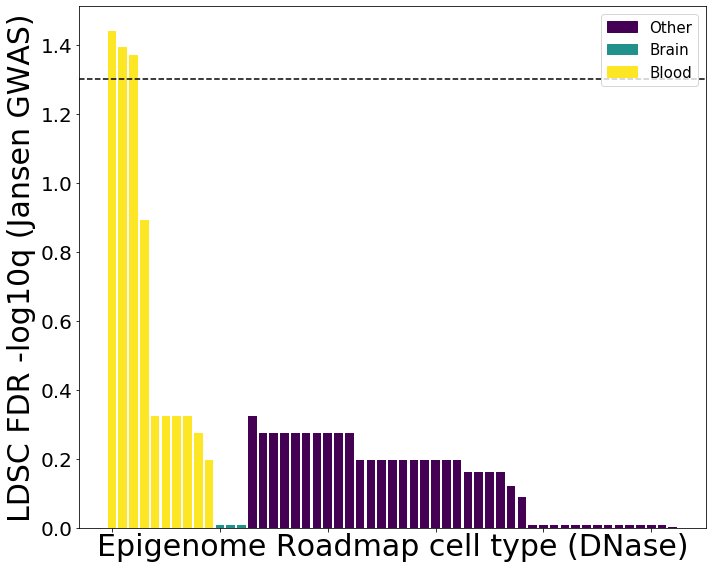

In [19]:
data = data.sort_values(['category_order', 'logfdr'], ascending=[True,False])
newData=data.reset_index()
dims = (10, 8)
fig,ax = plt.subplots(figsize=dims)
plt.tick_params(labelsize=20, labeltop=False, labelbottom=False)


plt.bar(range(newData.shape[0]),
        newData["logfdr"],
        color=[colorDict[val] for val in newData["category"]])
plt.axhline(y=-np.log10(0.05),linestyle='--',c='k')

plt.ylabel("LDSC FDR -log10q (Jansen GWAS)", fontsize=30)
plt.xlabel("Epigenome Roadmap cell type (DNase)", fontsize=30)
legendItems = [mpatches.Patch(color=colorDict[category], label=nameMapping[category]) for category in set(list(newData["category"]))]
plt.legend(handles=legendItems, fontsize=15, loc='upper right')
plt.tight_layout()
plt.savefig("roadmap_dnase_jansen_pval.svg")